In [ ]:
#!wget  http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2 
  
!pip install -U -q PyDrive
import os
from os import chdir, listdir, stat
from sys import exit
import ast
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.files import GoogleDriveFileList
import googleapiclient.errors


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

def upload_files(drive, folder_id, src_files, src_folder_name='.'):
    try:
        chdir(src_folder_name)
    except OSError:
        print(src_folder_name + ' is missing')
    for file1 in listdir('.'):
        statinfo = stat(file1)
        if file1 in src_files and statinfo.st_size > 0:
            print('Uploading ' + file1)
            f = drive.CreateFile(
                {"parents": [{"kind": "drive#fileLink", "id": folder_id}]})
            f.SetContentFile(file1)
            f.Upload()

def load_files(list_files):
  file_list = drive.ListFile(
    {'q': "'1fxDxf14ZuxOQVKmP4qKKIQI1ZOqMO8a7' in parents"}).GetList()

  for f in file_list:
    if f['title'] in list_files:
      print('title: %s, id: %s' % (f['title'], f['id']))
      fname = os.path.join(local_download_path, f['title'])
      print('downloading to {}'.format(fname))
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)  

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
#validation_images = train_images[50000:]
#train_images = train_images[:50000]

In [ ]:
#validation_labels = train_labels[50000:]
#train_labels = train_labels[:50000]

In [ ]:
# Reshape data to fit CNN model

train_images = train_images.reshape(60000,28,28,1) #one channel only (greyscale)
#validation_images = validation_images.reshape(10000,28,28,1)
test_images = test_images.reshape(10000,28,28,1)

In [ ]:
from keras.utils import to_categorical
#one-hot encode target column
train_labels = to_categorical(train_labels)
#validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)
train_labels[0]

Using TensorFlow backend.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
temperature = 1.2
model = keras.Sequential([
    keras.layers.Conv2D(128, kernel_size=3, activation='relu', input_shape=(28,28,1) , batch_input_shape =(1,28,28,1)),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Reshape((1,18432)),
    keras.layers.LSTM(32, stateful = True, input_shape = (1,18432),  batch_size=1),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32),
    keras.layers.Dropout(0.3),
    keras.layers.Lambda(lambda x: x / temperature ),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 26, 26, 128)          1280      
_________________________________________________________________
dropout (Dropout)            (1, 26, 26, 128)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 24, 24, 32)           36896     
_________________________________________________________________
dropout_1 (Dropout)          (1, 24, 24, 32)           0         
_________________________________________________________________
reshape (Reshape)            (1, 1, 18432)             0         
_________________________________________________________________
lstm (LSTM)                  (1, 32)                   2363520   
_________________________________________________________________
dropout_2 (Dropout)          (1, 32)                   0

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
# Instantiate a metric object
accuracy = tf.keras.metrics.CategoricalAccuracy()
loss_fn = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
#Train

for epoch in range(10):

  # Iterate over the batches of a dataset.
  for step, (x, y) in enumerate(zip(train_images, train_labels)):
    with tf.GradientTape() as tape:
      x = x.reshape(1, 28, 28, 1) #batch size equals 1
      probs = model(x)

      i=0
      input_LSTM = x
      for n in range(0,5):
        output = model.layers[n](input_LSTM)
        input_LSTM = output

      #random_value(0,1) < 1-tf.reduce_max(probs)
      #Standard uniform sampling (ex. np.random.rand)
      #Softmax temperature
      #Check tape update at the end of the loop
      #check example images
      while np.random.uniform(0,1) < 1-tf.reduce_max(probs):
        for n in range(5,11):
          if n == 5:
            output = model.layers[n](input_LSTM)  
          else:
            output = model.layers[n](input)
          input = output
        
        probs = output
      
      model.reset_states()

      # Compute the loss value for this batch.
      y = y.reshape(1,10)
      loss_value = loss_fn(y, probs)

    # Update the state of the `accuracy` metric.
    accuracy.update_state(y, probs)

    # Update the weights of the model to minimize the loss value.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    if step % 10000 == 0:
      print('Step:', step )        
      print('Total running accuracy so far: %.3f' % accuracy.result())


  print('Epoch:', epoch + 1)        
  print('Total running accuracy for this batch: %.3f' % accuracy.result())

  # Reset the metric's state at the end of an epoch
  accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Step: 0
Total running accuracy so far: 0.000
Step: 10000
Total running accuracy so far: 0.756
Step: 20000
Total running accuracy so far: 0.777
Step: 30000
Total running accuracy so far: 0.787
Step: 40000
Total running accuracy so far: 0.790
Step: 50000
Total running accuracy so far: 0.791
Epoch: 1
Total running accuracy for this batch: 0.791
Step: 0
Total running accuracy so far: 1.000
Step: 10000
Total running accuracy so far: 0.794
Step: 20000
Total running accuracy so far: 0.797
Step: 30000
Total run

KeyboardInterrupt: ignored

In [ ]:
folder_id = '1fxDxf14ZuxOQVKmP4qKKIQI1ZOqMO8a7'
model_name = "CNN_LSTM_4"

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open(model_name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_name+".h5")
print("Saved model to disk")
files = []
files.append(model_name+'.json')
files.append(model_name+'.h5')
upload_files(drive, folder_id, files)


Saved model to disk
Uploading CNN_LSTM_4.json
Uploading CNN_LSTM_4.h5


In [ ]:
temperature = 1.2
# load json and create model
files = []
files.append(model_name+'.json')
files.append(model_name+'.h5')
files_loaded  = load_files(files)
json_file = open('/root/data/' + model_name + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
model.load_weights('/root/data/' + model_name + '.h5')
print("Loaded model from disk")

'''
# evaluate loaded model on test data
loaded_model.compile ( loss='categorical_crossentropy' , optimizer='adam' , metrics = ['accuracy'] )
scores=loaded_model.evaluate(test_images, test_labels)
print("\n%s: %.2f%%" % (loaded_model.metrics_names[1] , scores[1]*100) )
'''

title: CNN_LSTM_4.h5, id: 1u-aVO0AWaGhr4kZhzelIxfFxPWus2SF6
downloading to /root/data/CNN_LSTM_4.h5
title: CNN_LSTM_4.json, id: 1LuEw2KqdjFThVQJIv9wFa_djQELdQ1mW
downloading to /root/data/CNN_LSTM_4.json
Loaded model from disk


'\n# evaluate loaded model on test data\nloaded_model.compile ( loss=\'categorical_crossentropy\' , optimizer=\'adam\' , metrics = [\'accuracy\'] )\nscores=loaded_model.evaluate(test_images, test_labels)\nprint("\n%s: %.2f%%" % (loaded_model.metrics_names[1] , scores[1]*100) )\n'

In [ ]:
#Test
fb_imgs = dict()
fb_labels = dict()

# Iterate over the batches of a dataset.
for step, (x, y) in enumerate(zip(test_images, test_labels)):

  x = x.reshape(1, 28, 28, 1) #batch size equals 1
  probs = model(x)

  i=0
  input_LSTM = x
  for n in range(0,5):
    output = model.layers[n](input_LSTM)
    input_LSTM = output
  while np.random.uniform(0,1) < 1-tf.reduce_max(probs):
    for n in range(5,11):
      if n == 5:
        output = model.layers[n](input_LSTM)  
      else:
        output = model.layers[n](input)
      input = output
        
    probs = output
    i = i+1
      
  if (i in fb_imgs):
    fb_imgs[i].append(x.reshape(28,28))
  else:
    fb_imgs[i] = [x.reshape(28,28)]

  if (i in fb_labels):
    fb_labels[i].append(np.argmax(y))
  else:
    fb_labels[i] = [np.argmax(y)]

  model.reset_states()

  # Compute the loss value for this batch.
  y = y.reshape(1,10)
  loss_value = loss_fn(y, probs)

  # Update the state of the `accuracy` metric.
  accuracy.update_state(y, probs)


print('Test accuracy: %.3f' % accuracy.result())

Test accuracy: 0.788


In [ ]:
import collections

fb_labels = collections.OrderedDict(sorted(fb_labels.items()))
class_names = {0: 'Top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

fb_percent = dict()
for c in fb_labels.keys():
  fb_percent[c] = {}
  for i in range(0,10):
    fb_percent[c][class_names[i]] =round ( (fb_labels[c].count(i) / len(fb_labels[c])) * 100, 2 )

In [ ]:
print(fb_percent)

{0: {'Top': 9.51, 'Trouser': 11.88, 'Pullover': 8.5, 'Dress': 9.67, 'Coat': 7.97, 'Sandal': 11.39, 'Shirt': 7.47, 'Sneaker': 10.46, 'Bag': 11.48, 'Ankle boot': 11.68}, 1: {'Top': 13.08, 'Trouser': 2.26, 'Pullover': 16.9, 'Dress': 10.83, 'Coat': 16.74, 'Sandal': 5.3, 'Shirt': 17.99, 'Sneaker': 8.49, 'Bag': 4.44, 'Ankle boot': 3.97}, 2: {'Top': 10.26, 'Trouser': 3.1, 'Pullover': 15.27, 'Dress': 11.46, 'Coat': 18.85, 'Sandal': 3.1, 'Shirt': 23.87, 'Sneaker': 8.11, 'Bag': 2.86, 'Ankle boot': 3.1}, 3: {'Top': 8.48, 'Trouser': 4.24, 'Pullover': 13.94, 'Dress': 9.7, 'Coat': 19.39, 'Sandal': 3.03, 'Shirt': 25.45, 'Sneaker': 7.88, 'Bag': 5.45, 'Ankle boot': 2.42}, 4: {'Top': 11.54, 'Trouser': 1.28, 'Pullover': 11.54, 'Dress': 12.82, 'Coat': 24.36, 'Sandal': 2.56, 'Shirt': 25.64, 'Sneaker': 6.41, 'Bag': 3.85, 'Ankle boot': 0.0}, 5: {'Top': 7.32, 'Trouser': 2.44, 'Pullover': 9.76, 'Dress': 26.83, 'Coat': 26.83, 'Sandal': 2.44, 'Shirt': 14.63, 'Sneaker': 7.32, 'Bag': 2.44, 'Ankle boot': 0.0}, 6: {

In [ ]:
class_percent = dict()
for c in range(0,10):
  class_percent[class_names[c]] = {}
  for i in fb_labels.keys():
    class_percent[class_names[c]][i] =round ( (fb_labels[i].count(c) / 10) , 2 )


In [ ]:
print(class_percent)

{'Top': {0: 75.9, 1: 16.8, 2: 4.3, 3: 1.4, 4: 0.9, 5: 0.3, 6: 0.2, 7: 0.2, 8: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}, 'Trouser': {0: 94.8, 1: 2.9, 2: 1.3, 3: 0.7, 4: 0.1, 5: 0.1, 6: 0.0, 7: 0.0, 8: 0.0, 10: 0.0, 11: 0.0, 12: 0.1}, 'Pullover': {0: 67.8, 1: 21.7, 2: 6.4, 3: 2.3, 4: 0.9, 5: 0.4, 6: 0.3, 7: 0.0, 8: 0.0, 10: 0.2, 11: 0.0, 12: 0.0}, 'Dress': {0: 77.2, 1: 13.9, 2: 4.8, 3: 1.6, 4: 1.0, 5: 1.1, 6: 0.1, 7: 0.1, 8: 0.2, 10: 0.0, 11: 0.0, 12: 0.0}, 'Coat': {0: 63.6, 1: 21.5, 2: 7.9, 3: 3.2, 4: 1.9, 5: 1.1, 6: 0.2, 7: 0.2, 8: 0.2, 10: 0.2, 11: 0.0, 12: 0.0}, 'Sandal': {0: 90.9, 1: 6.8, 2: 1.3, 3: 0.5, 4: 0.2, 5: 0.1, 6: 0.2, 7: 0.0, 8: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}, 'Shirt': {0: 59.6, 1: 23.1, 2: 10.0, 3: 4.2, 4: 2.0, 5: 0.6, 6: 0.3, 7: 0.0, 8: 0.0, 10: 0.1, 11: 0.1, 12: 0.0}, 'Sneaker': {0: 83.5, 1: 10.9, 2: 3.4, 3: 1.3, 4: 0.5, 5: 0.3, 6: 0.0, 7: 0.1, 8: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}, 'Bag': {0: 91.6, 1: 5.7, 2: 1.2, 3: 0.9, 4: 0.3, 5: 0.1, 6: 0.2, 7: 0.0, 8: 0.0, 10: 0.0, 11: 0.0, 

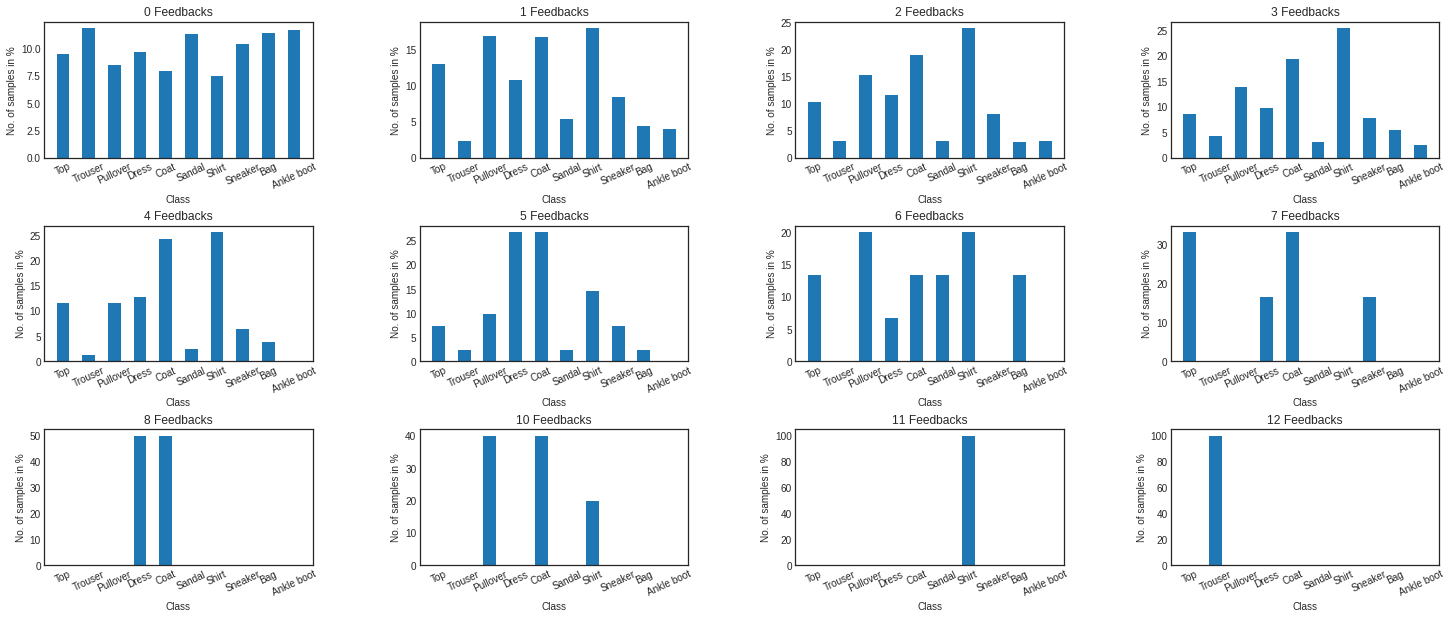

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
p = 1
for i in fb_percent.keys():
  a=plt.subplot(3,4,p)
  a.bar(fb_percent[i].keys(), fb_percent[i].values(), width=0.5)
  a.set_xlabel('Class')
  plt.xticks(rotation=25)
  a.set_ylabel('No. of samples in %')
  a.set_title(str(i) + ' Feedbacks')
  p+=1


plt.show()

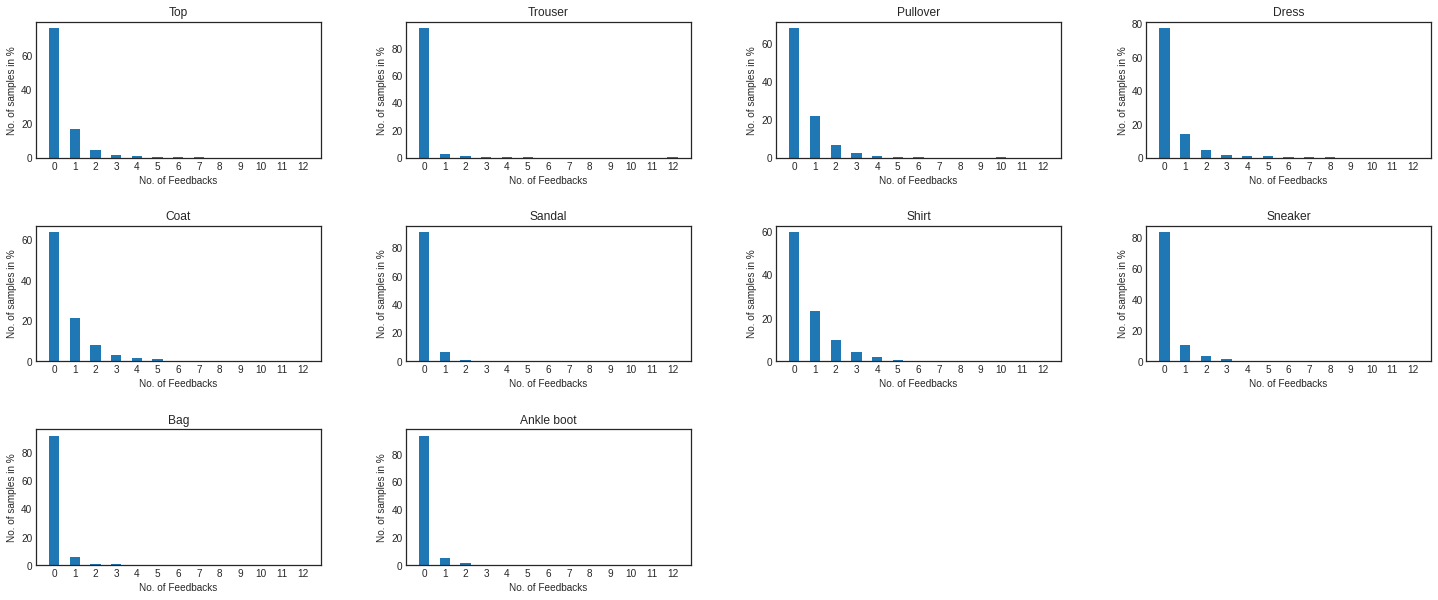

In [ ]:
fig = plt.figure(figsize=(25,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
p = 1
for i in class_percent.keys():
  a=plt.subplot(3,4,p)
  a.bar(class_percent[i].keys(), class_percent[i].values(), width=0.5)
  a.set_xlabel('No. of Feedbacks')
  plt.xticks(range(0,13))
  a.set_ylabel('No. of samples in %')
  a.set_title(i)
  p+=1


plt.show()

In [ ]:
import numpy as np

x_range = np.unique(np.array(n_feedback))
heights = np.zeros(x_range.size)

for element in n_feedback:
  heights[np.where(x_range == element)[0][0]] = heights[np.where(x_range == element)[0][0]] + 1

In [ ]:
print(x_range)
print(heights)

x_range = x_range[:8]

modified_heights = heights[:7]
modified_heights = np.append(modified_heights, np.sum(heights[7:]))


[0 1 2 3 4 5 6 7]
[6.582e+03 1.147e+03 1.360e+02 3.700e+01 5.700e+01 3.320e+02 1.663e+03
 1.500e+01 1.000e+00 4.000e+00 1.000e+00 2.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]


In [ ]:
modified_heights = (modified_heights / len(test_images)) * 100

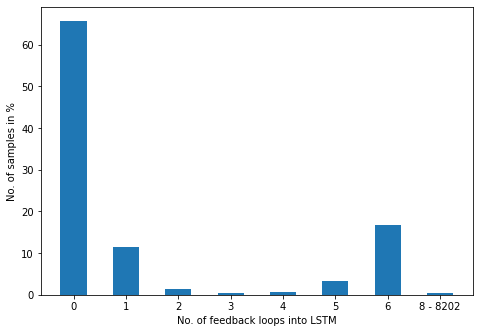

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_range, modified_heights, width=0.5)
ax.set_xticklabels(('0','0', '1', '2', '3', '4', '5', '6', '8 - 8202'))
ax.set_xlabel('No. of feedback loops into LSTM')
ax.set_ylabel('No. of samples in %')
plt.show()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0, batch_size = 1)
print('Test accuracy', test_acc)

Test accuracy 0.4699000120162964


In [ ]:
model.reset_states()

In [ ]:
'''input1 = train_images[0].reshape(1,28,28,1)
for n in range(0,5):
  output = model.layers[n](input1)
  input1 = output
print(tf.reduce_max(output))
print()'''

for n in range(5,10):
  if n == 5:
    output = model.layers[n](input1)
  else:
    output = model.layers[n](input)
  input = output
print(tf.reduce_max(output))
'''
while tf.reduce_max(output) < 0.999:
  print(tf.reduce_max(output))
  for n in range(5,10):
    if n == 5:
      output = model.layers[n](input1)
    else:
      output = model.layers[n](input)
    input = output

print(tf.reduce_max(output))
'''



tf.Tensor(0.9250483, shape=(), dtype=float32)


'\nwhile tf.reduce_max(output) < 0.999:\n  print(tf.reduce_max(output))\n  for n in range(5,10):\n    if n == 5:\n      output = model.layers[n](input1)\n    else:\n      output = model.layers[n](input)\n    input = output\n\nprint(tf.reduce_max(output))\n'